# Poland Visa Permit Data
There is a lot of controversy regarding the acceptance of immigrants from countries where the cultural background and to some extent, the religion processed are very different from the majoritarily western European, white, catholic Polish population. 
This study tries to assess whether there is a religious bias in the Visa Permit procedure (travel, work or study VISA) affecting the Visa Permit process chances of being accepted or rejected.
Another bias that could be expected is to easier accept persons coming from more developed countries where the health and education systems facilitate people achieving more in life. The Human Development Index (HDI) is an idicator that summarizes all that. 

Information on the HDI can be found here:
http://hdr.undp.org/en/content/human-development-index-hdi

The databases used have been the register of Visa petitions to enter Poland for the year 2019 and the ARDA (Association of Religion Data Archives) Cross-National Socio-Economic and Religion Data (2011). 
PL VISA: https://dane.gov.pl/dataset/1576,209e8d50-b703-4b71-a5c2-e1bff4ce6189/resource/23939/table?page=1&per_page=20&q=&sort=
ARDA: http://www.thearda.com/Archive/browse.asp
The ARDA database was actualized up to the year 2010. No significative changes were assumed in macro economy indicators like the Human Development Index (HDI) or the most professed religions by country.

There are only two years in the Polish Visa Permit database, 2018 and 2019, I decided to included only one year because neither politically, economically or almost in any sense are there any important differences between both years and because two years is too little to show any temporal progression. 

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from scipy import stats
import math
import matplotlib.patches as mpatches

data = pd.read_csv("https://raw.githubusercontent.com/WernerDJ/Poland_Visa_Data/master/Data/Statystyki_wizowe_-_2019.csv", delimiter =",") 
regions = pd.read_csv("https://raw.githubusercontent.com/WernerDJ/Poland_Visa_Data/master/Data/UNRegions.csv", delimiter =";") 
religions = pd.read_csv("https://raw.githubusercontent.com/WernerDJ/Poland_Visa_Data/master/Data/Religions.csv", delimiter =",") 
EconData = pd.read_csv("https://raw.githubusercontent.com/WernerDJ/Poland_Visa_Data/master/Data/Cross-National_Socio_Economic%20and%20Religion%20Data_%202011.csv", delimiter =",")
data['Visas_Petitions'] = data['SchengenVisas_Petitions'] + data['NonEU_Visas_Petitions']
data['Visas_Given'] = data['SchengenVisas_Given'] + data['NonEU_Visas_Given']
data['Visas_Rejected'] = data['SchengenVisas_Rejected'] + data['NonEU_Visas_Rejected']
data.iloc[87,0] = "Ukraine"
PL_Visas = data.iloc[:,[0,7,8,9]]
PLVisas = PL_Visas.rename(columns={'Origin Country ': 'Origin Country'})
AllData = pd.merge(PLVisas, EconData, left_on='Origin Country', right_on='ICOUNTRY')
AllData['Visas_Accepted in %'] = round(AllData['Visas_Given']*100/AllData['Visas_Petitions'],2)
AllData.head(5)

,Origin Country,Visas_Petitions,Visas_Given,Visas_Rejected,ARDACODE,WAVE,ICOUNTRY,UNREGION,ISO3,RELRECOD,UNINHDI,UNINLEPC,UNIN_INC,UNSATI,UNPOP10,Visas_Accepted in %
0,United Arab Emirates,2619,2086,524,232.0,2011.46,United Arab Emirates,21.0,ARE,6.0,NaN,0.846,NaN,7.266667,4.700000,79.65
1,Nigeria,2129,1051,1077,166.0,2011.46,Nigeria,20.0,NGA,6.0,0.246,0.220,0.298,3.766667,158.300000,49.37
2,Ethiopia,953,730,217,78.0,2011.46,Ethiopia,5.0,ETH,7.0,0.216,0.331,0.220,4.200000,85.000000,76.60
3,Algeria,3047,1791,1247,4.0,2011.46,Algeria,11.0,DZA,7.0,NaN,0.688,NaN,5.566667,35.366667,58.78
4,Kazakhstan,5631,4653,975,120.0,2011.46,Kazakhstan,15.0,KAZ,3.0,0.617,0.595,0.525,6.066667,15.800000,82.63



## Calculation of useful or missing values 
The value to be compared with the available data will be the percentage of Visas accepted, which will be included in the dataframe as a new column with the name "Visas_Accepted in %" 

The chances of being accepted will be contrasted with the religion majoritarily professed in the country of origin and with the variable Inequality-adjusted Human Development Index (UNINHDI) 2010. Some of the countries, as is the case of the United Arab Emirates, do not have a calculated IN_HDI. In order to be able to account for those countries in the calculation the region average IN_HDI could be taken into account, but as in the case uf UAE some of the neighbours might have a very different socio-economic situation, therefore it might be better to find a value strongly correlated to HDI and extrapolate the missing value from the other correlated variable.

In [2]:
corr = AllData.iloc[:,10:15].corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,UNINHDI,UNINLEPC,UNIN_INC,UNSATI,UNPOP10
UNINHDI,1.000000,0.859983,0.906554,0.642080,-0.209422
UNINLEPC,0.859983,1.000000,0.699282,0.735209,-0.105004
UNIN_INC,0.906554,0.699282,1.000000,0.552971,-0.196461
UNSATI,0.642080,0.735209,0.552971,1.000000,0.073286
UNPOP10,-0.209422,-0.105004,-0.196461,0.073286,1.000000


There are two variables that show a strong correlation to IN HDI (UNINHDI). The best correlated, with a Pearson correlation value of 0.89 is UNIN_INC (Inequality-adjusted income index), the next also highly correlated value is the UNINLEPC (Inequality-adjusted life expectancy at birth index) with a Pearson value or 0.84. Let's see if the correlation is close to linear

<IPython.core.display.Javascript object>


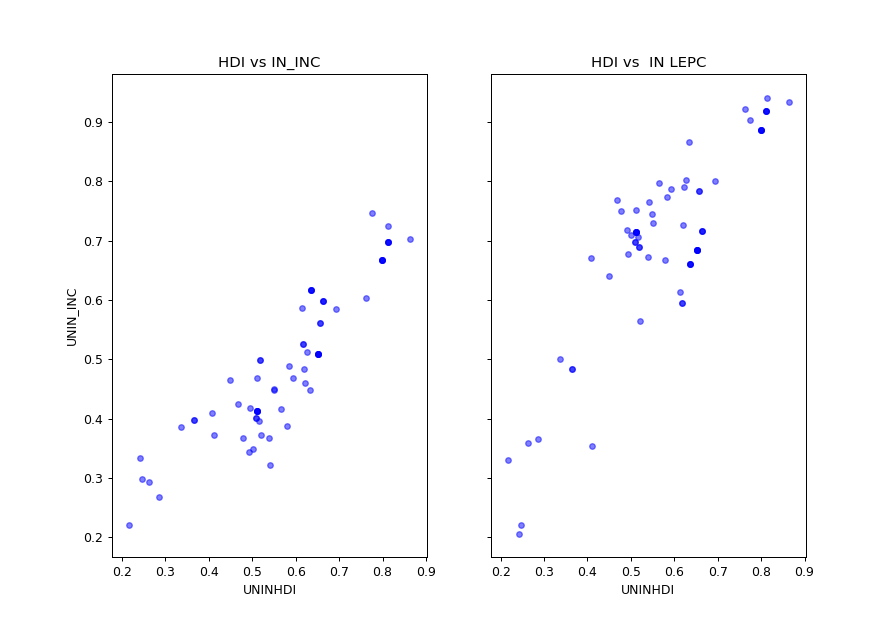

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('HDI vs IN_INC')
AllData.plot(kind='scatter', x='UNINHDI', y='UNIN_INC', color='blue', alpha=0.5, figsize=(10, 7), ax = ax1)
ax2.set_title('HDI vs  IN LEPC')
AllData.plot(kind='scatter', x='UNINHDI', y='UNINLEPC', color='blue', alpha=0.5, figsize=(10, 7), ax = ax2);

There is a seems to be a slight curve in the correlation lines but it is close enough to linear. The missing UNINHDI will be then predicted from the UNIN_INC value unless it is also Nan in which case it will be predicted from the UNINLEPC value, otherwise set the IN_HDI to the arbitrary value of 0.5


In [4]:
pd.options.mode.chained_assignment = None

def predictvalue(x, series):
    y = AllData['UNINHDI']
    mask = ~np.isnan(series) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(series[mask], y[mask])
    return slope*x + intercept
for n in range(len(AllData)):
    if math.isnan(AllData['UNINHDI'][n]):
        if math.isnan(AllData['UNIN_INC'][n]):
            if math.isnan(AllData['UNINLEPC'][n]):
                AllData['UNINHDI'][n] = 0.5
            else:            
                x = AllData['UNINLEPC'][n]
                series = AllData['UNINLEPC'] 
                AllData['UNINHDI'][n] = predictvalue(x, series)
        else: 
            x = AllData['UNIN_INC'][n]
            series = AllData['UNIN_INC'] 
            AllData['UNINHDI'][n] = predictvalue(x, series)
#            
corel = np.corrcoef(AllData['UNINHDI'],AllData['Visas_Accepted in %'])[0][1]
print('\nThe correlation between the UN provided HDI and the percentage of Visa Permit Acceptance is:\n Pearson = {}'.format(corel))


The correlation between the UN provided HDI and the percentage of Visa Permit Acceptance is:
 Pearson = 0.6583299182026371


The correlation of Travel Visa acceptance with HDI is quite high. Since religion is a categorical data, 
to see if there is any bias towards a certain religion let us see what the data itself can visually express

<IPython.core.display.Javascript object>


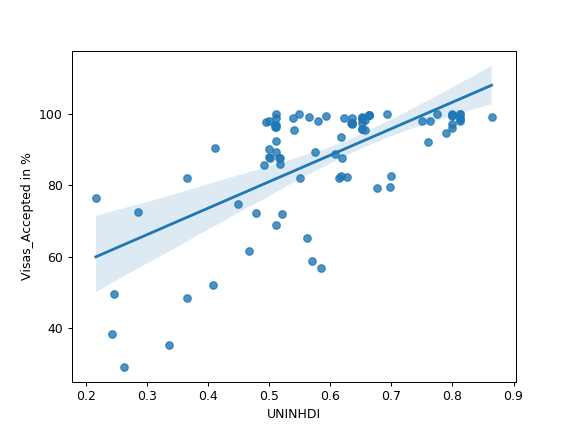

In [5]:
%matplotlib notebook
sns.regplot(x='UNINHDI', y="Visas_Accepted in %", data=AllData);

When the UN Inequality-adjusted Human Development Index (UNINHDI) is bellow 0.5 the possibilities of the Visa permit being conceded are very variable, above that value there seems to be a group of countries with a near 100% chances and others that allign closely to the linear regression curve. In order to identify which those countries might be a bar plot with the coutries with most numerous Travel Visa petitiones is shown bellow aside a graphic depicting the % of visa acceptance in those selected countries

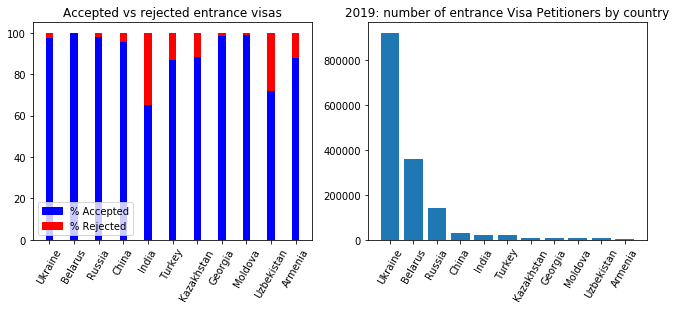

In [7]:
%matplotlib inline
plotY = AllData.groupby('ICOUNTRY').sum()['Visas_Petitions']
plotAc = AllData.groupby('ICOUNTRY').mean()['Visas_Accepted in %']
Most = plotY[plotY>5000]
Mosts = Most[[sorted(range(len(Most)), key=lambda k: Most[k], reverse = True)][0]]
ys = []
for countr in Mosts.index:
    ys.append(plotAc[countr])
# 
# Plots organization in subplots, labels and other esthetic aspects
#
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(11,4))
#
patches = []
patches.append(mpatches.Patch(color='blue', label="% Accepted"))
patches.append(mpatches.Patch(color='red', label="% Rejected"))
ax1.legend(handles=patches)
ax1.set_xticklabels(Mosts.index, rotation=60)
ax1.set_title('Accepted vs rejected entrance visas')
ax2.set_xticklabels(Mosts.index, rotation=60)
ax2.set_title('2019: number of entrance Visa Petitioners by country')
#
# The plots themselves
#
r1 = ax1.bar(Mosts.index, ys, width = 0.3, color='b')
r2 = ax1.bar(Mosts.index, [100 - x for x in ys], width = 0.3, bottom=ys, color='r')
r3 = ax2.bar(Mosts.index, Mosts);

As seen in the graphics above the vast majority of immigrants to Poland come from Eastern European countries.  Ucrainians, specially speak a very similar language and are culturally very close to Poland. Those immigrants fill to a great exgtent the vacuum left by the Poles that emigrated mainly to England and Germany once the EU borders were opened to Poland. 

# Identify the Countries by World Region 

Bellow shown is an interactive scatter plot of [%]Visa Aceptance versus Human Development index. The country dots are coloured according to the geographical world region to which the country belongs and clicking in the dots will show in the graphic title the name of that country

In [8]:
%matplotlib notebook
plotAc = AllData.groupby('ICOUNTRY').mean().reset_index()
OnlyCountry = pd.merge(plotAc, regions, left_on='UNREGION', right_on='UNREGION')

In [9]:
def onpick(event):
    origin = OnlyCountry.iloc[event.ind[0]]['ICOUNTRY']
    plt.gca().set_title('Selected item came from {}'.format(origin))

<IPython.core.display.Javascript object>


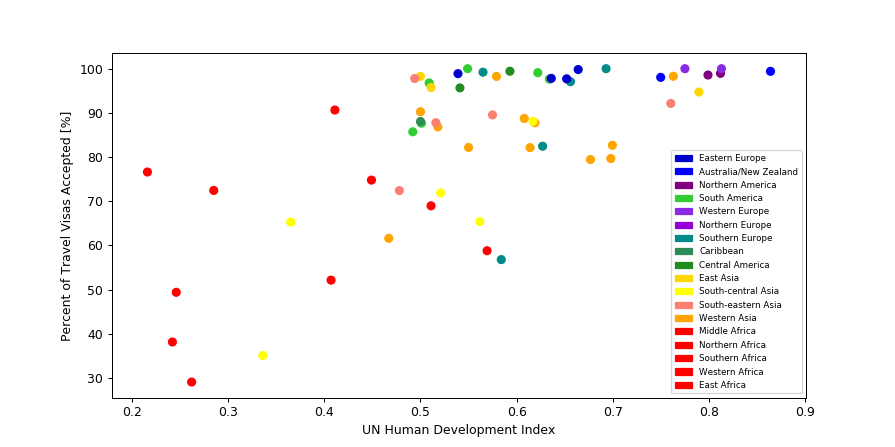

In [11]:
ColorCount = {'Eastern Europe':'mediumblue', 'Australia/New Zealand': 'blue', 'Northern America':'purple', 
              'South America':'limegreen', 'Western Europe':'blueviolet', 'Northern Europe':'darkviolet', 
              'Southern Europe':'darkcyan','Caribbean':'seagreen', 'Central America':'forestgreen', 
               'East Asia':'gold','South-central Asia':'yellow',
              'South-eastern Asia':'salmon','Western Asia':'orange','Middle Africa':'red','Northern Africa':'red', 
              'Southern Africa':'red','Western Africa':'red','East Africa':'red'}

plt.figure(figsize=(10, 5))
plt.ylabel("Percent of Travel Visas Accepted [%]")
plt.xlabel("UN Human Development Index")
patches2 = []
for countr in ColorCount.keys():
    patches2.append(mpatches.Patch(color=ColorCount[countr], label=countr))
colours02 = [ColorCount[countr] for countr in OnlyCountry['UN Region']]
plt.scatter(OnlyCountry['UNINHDI'],OnlyCountry['Visas_Accepted in %'], c = colours02, s =40, picker=1)
plt.legend(handles=patches2, fontsize=7)
plt.gcf().canvas.mpl_connect('pick_event', onpick);

# Identify the Countries by Religion

Bellow shown is an interactive scatter plot of [%]Visa Aceptance versus Human Development index. The country dots are coloured according to the largest religion professed in that country. East European Countries might be overrepresented for reasons connected rather with viccinity and income difference, reason why they have been eliminated from the graphic. Clicking in the dots will show in the graphic title the name of that country.

In [12]:
religions.iloc[10,0] = 'Jewish' #Correcting a funny mistake by which Israel's main religion was Animism
OnlyCountryRel = pd.merge(OnlyCountry, religions, left_on='RELRECOD', right_on='RELRECOD')
NonEastern = OnlyCountryRel[(OnlyCountryRel['UNREGION'] != 7)]
def onpick(event):
    origin = NonEastern.iloc[event.ind[0]]['ICOUNTRY']
    plt.gca().set_title('Selected item came from {}'.format(origin))

<IPython.core.display.Javascript object>


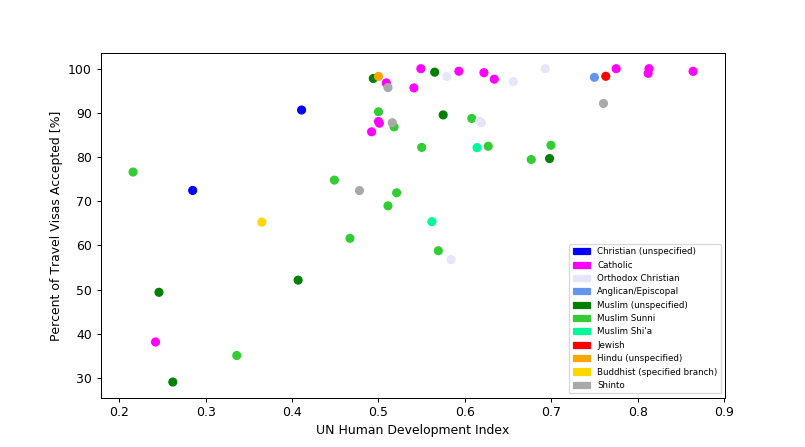

In [13]:
ColorRels ={'Christian (unspecified)':'blue','Catholic': 'magenta', 'Orthodox Christian':'lavender',
            'Anglican/Episcopal':'cornflowerblue', 'Muslim (unspecified)':'green', 'Muslim Sunni':'limegreen',
           "Muslim Shi'a":'mediumspringgreen','Jewish':'red','Hindu (unspecified)':'orange',
           'Buddhist (specified branch)':'gold', 'Shinto':'darkgray'}
# Lest's plot the proportions of conceded Travel Visas for al countries without Eastern European Countries
plt.figure(figsize=(9, 5))
plt.ylabel("Percent of Travel Visas Accepted [%]")
plt.xlabel("UN Human Development Index")
patches = []
for religion in ColorRels.keys():
    patches.append(mpatches.Patch(color=ColorRels[religion], label=religion))
colours01 = [ColorRels[reli] for reli in NonEastern['Largest_Religion']]
plt.scatter(NonEastern['UNINHDI'],NonEastern['Visas_Accepted in %'], c = colours01, s =40, picker=1)
plt.legend(handles=patches, fontsize=7)
plt.gcf().canvas.mpl_connect('pick_event', onpick);

# Conclusion

There is a strong correlation between the Human Development Index (HDI) of the country of procendece of the Travel Visa requesters and the possibilities of that Visa being conceded. That correlation indicates that the main concern when a Travel Visa to Poland is being processed are connected with those factors that define the Human Development Indicator, mostly Health status and Education level.

The vast majority of the immigrants to Poland come from Eastern Europe, which is a majoritarily Christian Ortodox region, however the eagerness of the Polish authorities to accept their entrance is mostly due to the similarity of their cultural traits.

Eliminating the Eastern European countries from the graphic leaves a picture in which the most favoured countries when their HDI is taken into account are majoritarily Christian, and to a great extend Catholic. The graphic where countries are cloured by religion clearly shows that for HDI above 0.5 non Christian Countries have worse acceptance rates than Christian. 

A multivariate logistic regression analysis cound give more light into that matter however, more variables should be taken into account and data coming from  the reports of personal Visa requests would be necessary to eliminate possible confounders.


In view of the analyzed data seems then that cultural closeness is an important factor in the Travel Visa Acceptance by the Polish authorities and that the professed religion might be taken as an indicator of that closeness. 



This study, code, csv files used and the notebook itself are free to use, copy, donwload and modify from the github repository https://github.com/WernerDJ/Poland_Visa_Data

However I, Werner Deichmann Juan, retain the authorship (R) 2020 and thus any inclusion of this work or part of it in another one requires to mention the data source, that is me, of course.